# Notebook Overview

## Motivation
Users frequently engage in long conversations with LLMs with the expectation that the LLM fully recalls what was said in the previous turns.
The way we make LLMs aware of previous information is by simply providing them the full conversation history, i.e., the concatenation of previous input queries and generations.

As Agents become more and more used, we face the issue to make Agents fully aware of the info from previous turns.
The current approach is to pass the Agent the generations of the previous turns (see https://python.langchain.com/docs/modules/agents/how_to/custom_agent/). However, as we show below, while this is a good approach for LLMs it is not for Agents. Given the same input, LLMs *only* produce the final generation; conversely, Agents *first* produce a reasoning chain (intermediate steps), *then* produce the final outcome. Hence, if we only retain the final generation we lose some crucial info: the reasoning chain.

A straightforward solution to this issue would be to append to the conversation history from both the reasoning chain and the generations. This is problematic due to the fact that reasoning chains can be very long, especially when the model makes mistakes and corrects itself. Using the full reasoning chains would (i) introduce a lot of noise; (ii) quickly fill the whole input window of the model.

## Objective

In this notebook we introduce a simple approach to address the issue described above. We propose to use *augmented memory objects*, which we define as compact and interpretable pieces of information based on the reasoning chain and the generation.

Below, we show that, with augmented memory objects, the Agent is more aware of the information that emerged in the conversation, and, in turn, this makes the Agent behaviour more robust and effective.

## Table of Contents

- [Step 1: Setup the Prompt and the Agent](#sec_step1)
- [Step 2: Conversation without memory](#sec_step2)
- [Step 3: Conversation with Memory using AI Messages](#sec_step3)
- [Step 4: Conversation with Memory using AI Messages and Human Messages](#sec_step4)
- [Step 5: Conversation with Memory using AI Messages and Human Messages](#sec_step5)

<a name="sec_step1"></a>
# Step 1: Setup the Prompt and the Agent

In [ ]:
# Uncomment if you need to install the following packages
# !pip install cohere
# !pip install python-dotenv
# !pip install pandas

In [17]:
import os
import pandas as pd
import getpass
from langchain_core.prompts import ChatPromptTemplate
from langchain_experimental.utilities import PythonREPL
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.agents import Tool
from langchain_cohere.chat_models import ChatCohere
from langchain_cohere.react_multi_hop.agent import create_cohere_react_agent
from langchain.agents import AgentExecutor
from langchain_core.messages.ai import AIMessage
from langchain_core.messages.system import SystemMessage
from langchain_core.messages.human import HumanMessage

In [2]:
# load the cohere api key
os.environ["COHERE_API_KEY"] = getpass.getpass()

In [3]:
# Load the data
revenue_table = pd.read_csv('revenue_table.csv')

In [4]:
# Define the prompt
prompt = ChatPromptTemplate.from_template("{input}")

In [5]:
# Define the tools
python_repl = PythonREPL()
python_tool = Tool(
    name="python_repl",
    description="Executes python code and returns the result. The code runs in a static sandbox without interactive mode, so print output or save output to a file.",
    func=python_repl.run,
)
python_tool.name = "python_interpreter"

class ToolInput(BaseModel):
    code: str = Field(description="Python code to execute.")
python_tool.args_schema = ToolInput

tools=[python_tool]

In [18]:
# Define the agent
llm = ChatCohere(model="command-r", temperature=0)

# instantiate agent and agent executor
agent = create_cohere_react_agent(
   llm=llm,
   tools=tools,
   prompt=prompt,
)
agent_executor = AgentExecutor(agent=agent,
                               tools=tools,
                               verbose=True,
                               return_intermediate_steps=True
                    )

<a name="sec_step2"></a>
# Step 2: Conversation without memory


In [10]:
# let's start the conversation with a question about the csv we have loaded
q1 = "read revenue_table.csv and show me the column names"
a1=agent_executor.invoke({
   "input": q1,
})



> Entering new AgentExecutor chain...

I will use python to read the CSV file and extract the column names.
{'tool_name': 'python_interpreter', 'parameters': {'code': "import pandas as pd\n\ndf = pd.read_csv('revenue_table.csv')\n\nprint(df.columns)"}}
Index(['Unnamed: 0', 'time', 'revenue', 'loss'], dtype='object')
Relevant Documents: 0
Cited Documents: 0
Answer: The column names in the CSV file are:
- Unnamed: 0
- time
- revenue
- loss
Grounded answer: The column names in the CSV file are:
- <co: 0>Unnamed: 0</co: 0>
- <co: 0>time</co: 0>
- <co: 0>revenue</co: 0>
- <co: 0>loss</co: 0>

> Finished chain.


In [12]:
# nice! now let's ask a follow-up question
q2 = "plot revenue numbers"
a2_no_mem = agent_executor.invoke({
   "input": q2,
})



> Entering new AgentExecutor chain...
Plan: I will ask the user for clarification on what data they would like to visualise.
Action: ```json
[
    {
        "tool_name": "directly_answer",
        "parameters": {}
    }
]
```
Relevant Documents: None
Cited Documents: None
Answer: Hello, could you please clarify what data you would like to see plotted?
Grounded answer: Hello, could you please clarify what data you would like to see plotted?

> Finished chain.


Without memory, the model cannot answer follow up questions because it misses the necessary previous context

<a name="sec_step3"></a>
# Step 3. Conversation with Memory using AI Messages

Here we will populate the chat history only with the generations from the model. This is the current approach used, e.g., here: https://python.langchain.com/docs/modules/agents/how_to/custom_agent/

In [88]:
# let's answer the followup question above with the new setup
a2_mem_ai = agent_executor.invoke({
   "input": q2,
   "chat_history": [AIMessage(content=a1['output'])] # we add here the generation of the model at turn 1
})



> Entering new AgentExecutor chain...

I will copy and paste the code from the previous conversation and add code to plot the revenue numbers.
{'tool_name': 'python_interpreter', 'parameters': {'code': "import pandas as pd\nimport matplotlib.pyplot as plt\n\ndata = pd.read_csv('data/sample.csv')\n\n# Plot revenue numbers\nplt.plot(data['revenue'])\n\nplt.savefig('revenue_plot.png')"}}
FileNotFoundError(2, 'No such file or directory')
The code is throwing an error because the file doesn't exist in the specified location. I will amend the file path and re-run the code.
{'tool_name': 'python_interpreter', 'parameters': {'code': "import pandas as pd\nimport matplotlib.pyplot as plt\n\ndata = pd.read_csv('sample.csv')\n\n# Plot revenue numbers\nplt.plot(data['revenue'])\n\nplt.savefig('revenue_plot.png')"}}
FileNotFoundError(2, 'No such file or directory')
The file path is still incorrect. I will amend it and re-run the code.
{'tool_name': 'python_interpreter', 'parameters': {'code': "imp

Also in this case, the model cannot manage the follow up question. The reason is that the AI message only tells part of the necessary context: we need more info from previous turns.


<a name="sec_step4"></a>
# Step 4: Conversation with Memory using AI Messages and Human Messages



> Entering new AgentExecutor chain...

I will copy and paste the code from the previous conversation into this one, and then use it to plot the revenue numbers.
{'tool_name': 'python_interpreter', 'parameters': {'code': "import pandas as pd\nimport matplotlib.pyplot as plt\n\ndata = pd.read_csv('modified_revenue_table.csv')\n\n# Plot the revenue numbers\nplt.plot(data['revenue'])\n\nplt.savefig('revenue_plot.png')"}}
Relevant Documents: 0
Cited Documents: 0
Answer: Here's a plot of the revenue numbers:
![Revenue plot]("revenue_plot.png")
Grounded answer: Here's a plot of the revenue numbers:
<co: 0>! [Revenue plot]("revenue_plot.png")</co: 0>

> Finished chain.


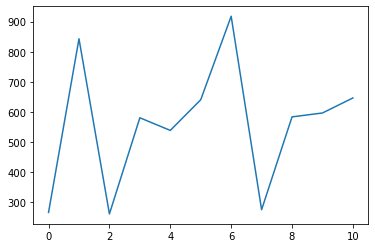

In [14]:
a2_mem_ai_hum = agent_executor.invoke({
   "input": q2,
   "chat_history": [HumanMessage(content=q1),
                    AIMessage(content=a1['output'])] # we add here the human query and the generation of the model at turn 1
})

It works! Let's go on with the conversation.



> Entering new AgentExecutor chain...

I will copy and paste the previous code and make the changes requested by the user. Then I will execute the code to plot the graph with the changes applied.
{'tool_name': 'python_interpreter', 'parameters': {'code': 'import pandas as pd\nimport matplotlib.pyplot as plt\n\n# Read the CSV file into a DataFrame\ndf = pd.read_csv("modified_revenue_table.csv")\n\n# Plot revenue against time\nplt.plot(df["time"], df["revenue"], marker="o")\n\n# Set minimum and maximum values for y-axis\nplt.ylim(0, 1000)\n\nplt.savefig("revenue_plot.png")'}}
Relevant Documents: 0
Cited Documents: 0
Answer: Here's the plot with the requested changes:
![Revenue plot]("revenue_plot.png")
Grounded answer: Here's the plot with the requested changes:
<co: 0>! [Revenue plot]("revenue_plot.png")</co: 0>

> Finished chain.


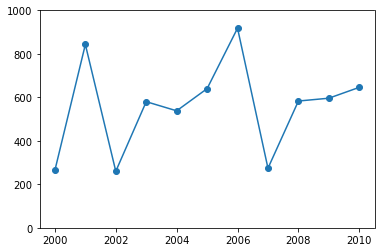

In [15]:
q3 = "set the min of y axis to zero and the max to 1000"
a3_mem_ai_hum = agent_executor.invoke({
   "input": q3,
   "chat_history": [HumanMessage(content=q1),
                    AIMessage(content=a1['output']),
                    HumanMessage(content=q2), # we now add info from turn 2
                    AIMessage(content=a2_mem_ai_hum['output'])]
})

The model does what we asked, but it decides to introduce the marker="o" in the plotting function. While in this case the modification of the code does not affect the quality of the output, this is still an undesidered behaviour, since the model is introducing a modification that was not required.

To address this problem, we can further enrich the chat history by adding information from the reasoning chain.


<a name="sec_step5"></a>
# Step 5: Conversation with Memory using AI Messages, Human Messages and the Reasoning Chain

Reasoning chains can be very long, especially in the cases that contain errors and the agent needs several attempts to get to the final output. Hence, by concatenating all the reasoning chains, we might have two issues: (i) noisy information; (ii) we would quickly hit max input length.

To avoid this issue, we need a way to extract the relevant info from the previous turns. Below, we propose a simple approach to info extraction. We format the extracted info in such a way to enhance human interpretability. We call the objects passed in the chat history *augmented memory objects*.

In [14]:
# function to create augmented memory objects
def create_augmented_mem_objs(output_previous_turn: dict) -> str:
    """Function to convert the output of a ReAct agent to a compact and interpretable representation"""
    all_steps_info = []
    # loop though the steps of the previous turns
    for i, step in enumerate(output_previous_turn['intermediate_steps']):
        # remove failed attempts
        if "error" not in step[1].lower():
            # collect the relevant info
            step_info = {'tool': step[0].tool,
                         'tool_input': step[0].tool_input}
            all_steps_info.append(step_info)
    # format the memory object in an interpretable way
    augmented_mem_obj = "This is the sequence of tools you used in the previous turn:\n"
    for i, item in enumerate(all_steps_info):
        augmented_mem_obj = augmented_mem_obj + f"\nSTART TOOL {i} NAME:\n{item['tool']}\nEND TOOL {i} NAME" \
                                                f"\n\nSTART INPUT {i} NAME:\n{item['tool_input']}\nEND INPUT {i} NAME\n"
    # add the final output generated by the agent
    augmented_mem_obj = augmented_mem_obj + f"\n\nThis is the output you produced in the previous turn:\nSTART OUTPUT\n{output_previous_turn['output']}\nEND OUTPUT"

    return augmented_mem_obj

In [91]:
augmented_mem_obj_a1 = create_augmented_mem_objs(a1)
augmented_mem_obj_a2 = create_augmented_mem_objs(a2_mem_ai_hum)

Below, an example of the augmented memory object generated by the model. You can see that the agent now has full visibility on what it did in the previous step.

In [92]:
print(augmented_mem_obj_a2)

This is the sequence of tools you used in the previous turn:

START TOOL 0 NAME:
python_interpreter
END TOOL 0 NAME

START INPUT 0 NAME:
{'code': "import pandas as pd\nimport matplotlib.pyplot as plt\n\ndata = pd.read_csv('modified_revenue_table.csv')\n\n# Plot the revenue numbers\nplt.plot(data['revenue'])\n\nplt.savefig('revenue_plot.png')"}
END INPUT 0 NAME


This is the output you produced in the previous turn:
START OUTPUT
Here's a plot of the revenue numbers:
! [Revenue plot]("revenue_plot.png")
END OUTPUT




> Entering new AgentExecutor chain...

I will copy and paste the previous code, and modify the y axis limits as requested.
{'tool_name': 'python_interpreter', 'parameters': {'code': "import pandas as pd\nimport matplotlib.pyplot as plt\n\ndata = pd.read_csv('modified_revenue_table.csv')\n\n# Plot the revenue numbers\nplt.plot(data['revenue'])\n\n# Set y axis limits\nplt.ylim(0, 1000)\n\nplt.savefig('revenue_plot.png')"}}
Relevant Documents: 0
Cited Documents: 0
Answer: Here's the plot with the requested y axis limits:

![Revenue plot]("revenue_plot.png")
Grounded answer: Here's the plot with the requested y axis limits:

<co: 0>! [Revenue plot]("revenue_plot.png")</co: 0>

> Finished chain.


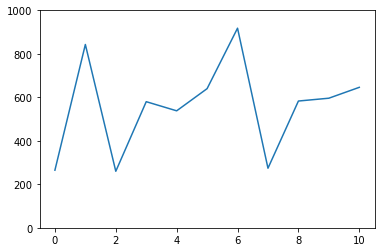

In [87]:
a3_mem_ai_hum_amo = agent_executor.invoke({
    "input": q3,
    "chat_history": [SystemMessage(content=augmented_mem_obj_a1),
                     SystemMessage(content=augmented_mem_obj_a2)]
})


We can see that, now, the plot only includes the modification we asked for, and nothing else. This is possible because we are now providing the Agent with the code it previously generated, and the Agent re-uses that code, making only the necessary modifications. This is fundamentally different from what we observed before, when the Agent had to re-create from scratch the code.

In sum, by providing the Agent with the information about its previous Reasoning Chain, we make it more robust and able to generate consistent outputs.

In a future post, we will explore how to handle really long historical context using vector databases.